In [1]:
!pip install yfinance --quiet

In [2]:
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (22,5)

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score
from datetime import date

In [3]:
data = yf.Ticker("GOOGL")
data_hist = data.history(period="max")
data_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.499634,2.601119,2.398648,2.508132,893181924,0.0,0.0
2004-08-20 00:00:00-04:00,2.524880,2.726600,2.512132,2.707353,456686856,0.0,0.0
2004-08-23 00:00:00-04:00,2.768345,2.836584,2.725851,2.734599,365122512,0.0,0.0
2004-08-24 00:00:00-04:00,2.780593,2.789591,2.588871,2.621365,304946748,0.0,0.0
2004-08-25 00:00:00-04:00,2.623616,2.699605,2.596620,2.649612,183772044,0.0,0.0
...,...,...,...,...,...,...,...
2024-07-08 00:00:00-04:00,189.899994,190.169998,187.779999,189.029999,21035900,0.0,0.0
2024-07-09 00:00:00-04:00,190.309998,191.360001,188.720001,188.979996,15121400,0.0,0.0
2024-07-10 00:00:00-04:00,189.149994,191.750000,189.029999,191.179993,15952500,0.0,0.0


In [4]:
print(f'The data has {data_hist.shape[0]} rows and {data_hist.shape[1]} columns')

The data has 5008 rows and 7 columns


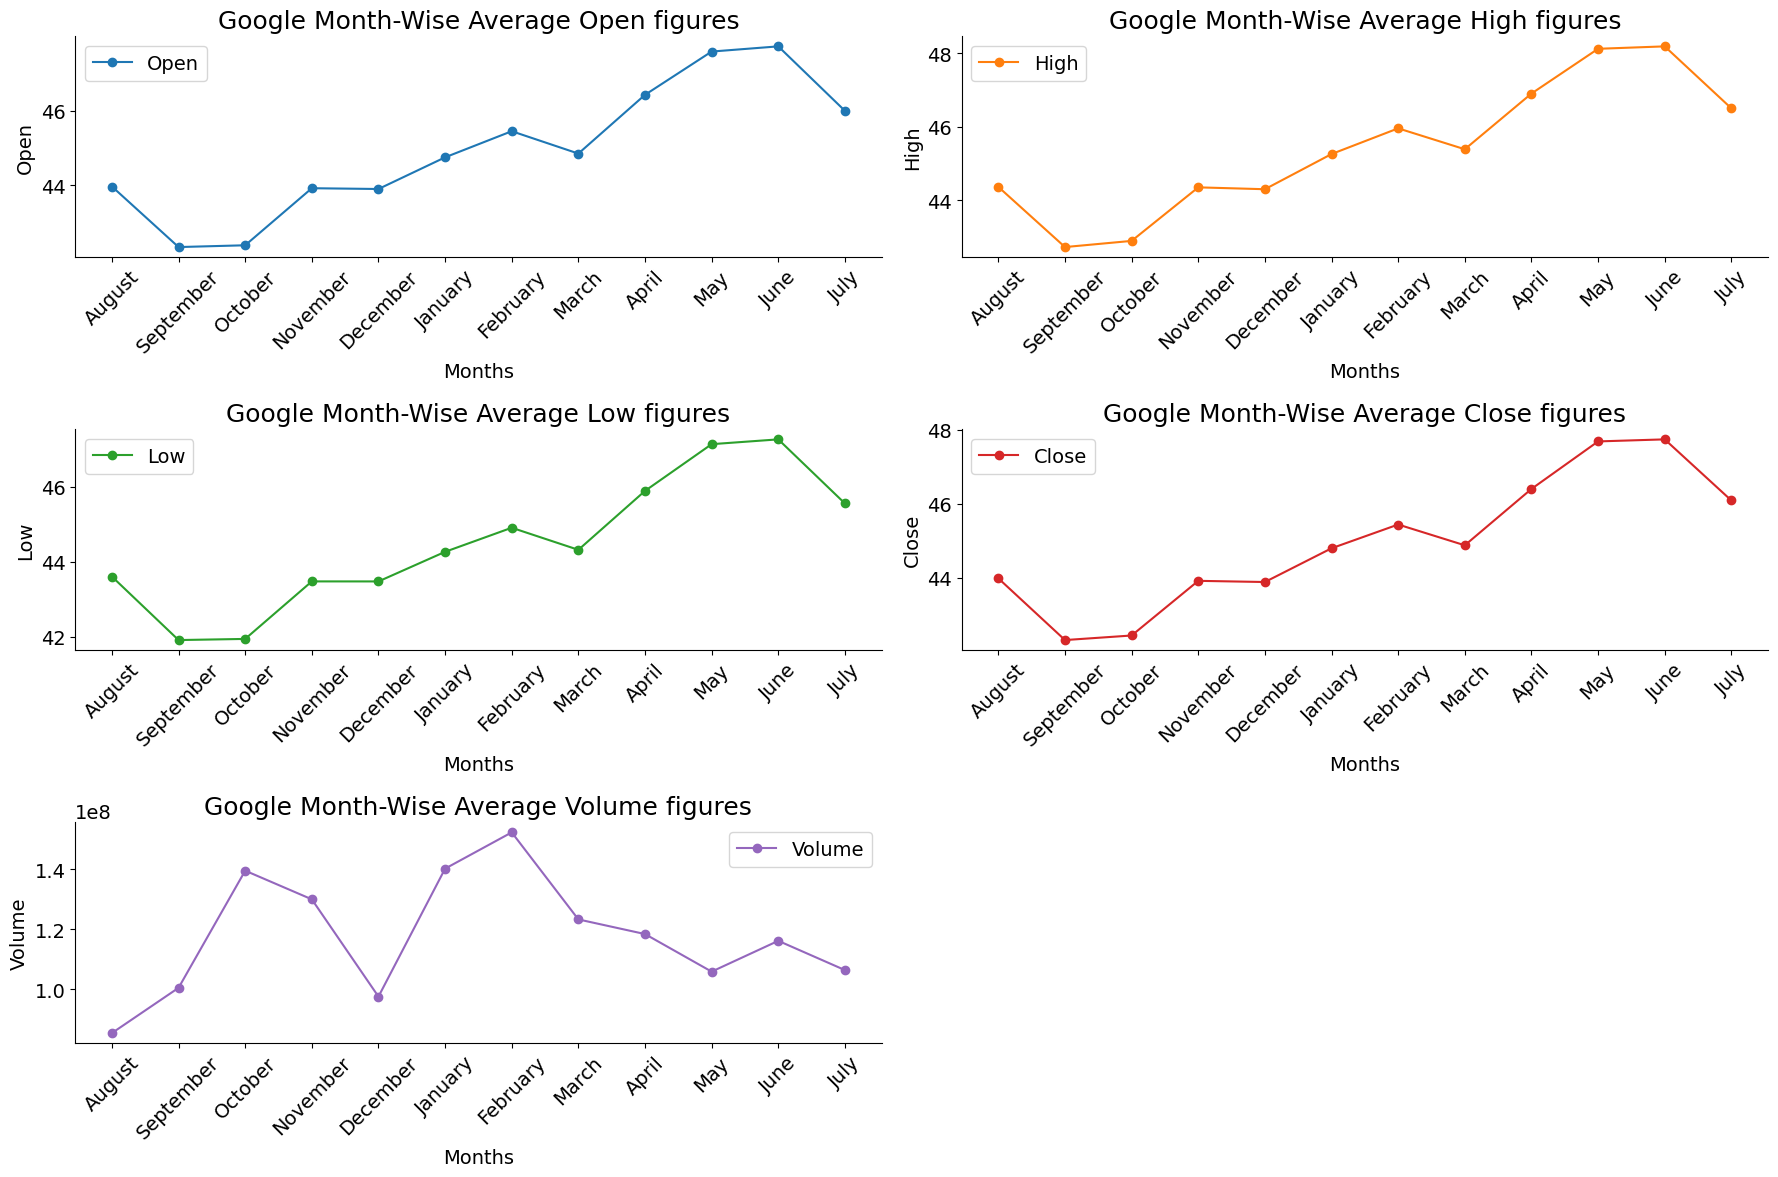

In [5]:
colors = plt.rcParams["axes.prop_cycle"]()
a = 3
b = 2
c = 1

fig = plt.figure(figsize=(18,12))

for i in range(len(data_hist.groupby(data_hist.index.month_name(), sort=False).mean().columns[:-2])):
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    plt.plot(data_hist.groupby(data_hist.index.month_name(), sort=False).mean().iloc[:, i], color= color, marker='o')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=45)
    plt.title(f"Google Month-Wise Average {data_hist.groupby(data_hist.index.month_name(), sort=False).mean().iloc[:, i].name} figures", fontsize=18)
    plt.xlabel('Months')
    plt.ylabel(data_hist.groupby(data_hist.index.month_name(), sort=False).mean().iloc[:, i].name)
    plt.legend([data_hist.groupby(data_hist.index.month_name(), sort=False).mean().iloc[:, i].name])
    c = c + 1

plt.tight_layout()
plt.show()

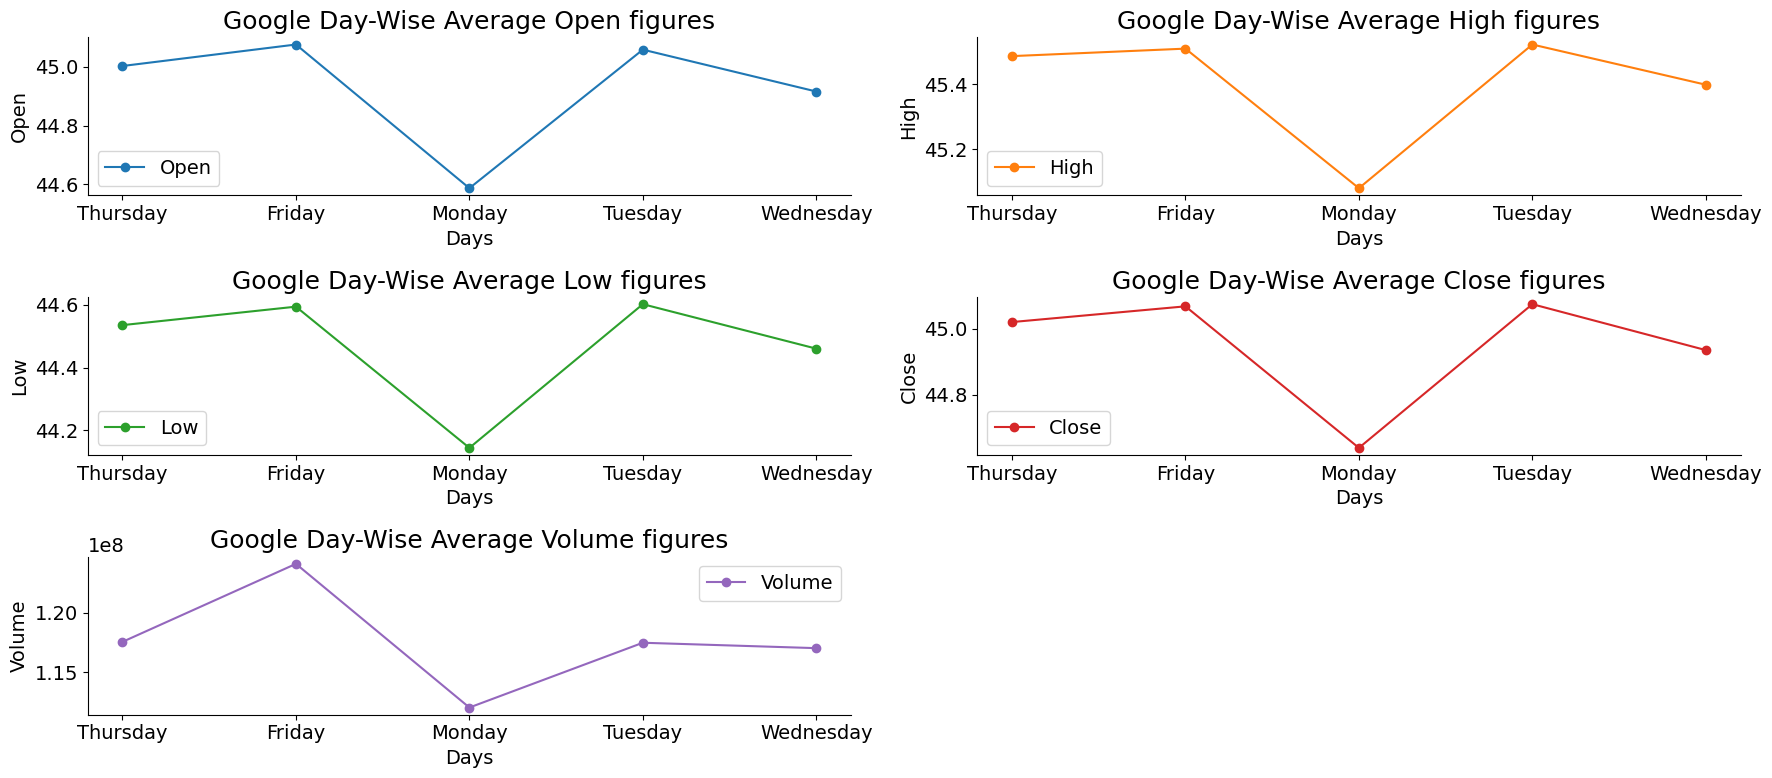

In [6]:
a = 3
b = 2
c = 1
colors = plt.rcParams["axes.prop_cycle"]()

fig = plt.figure(figsize=(18,8))

for i in range(len(data_hist.groupby(data_hist.index.day_name(), sort=False).mean().columns[:-2])):
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    plt.plot(data_hist.groupby(data_hist.index.day_name(), sort=False).mean().iloc[:, i], color= color, marker='o')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(rotation=0)
    plt.title(f"Google Day-Wise Average {data_hist.groupby(data_hist.index.day_name(), sort=False).mean().iloc[:, i].name} figures", fontsize=18)
    plt.xlabel('Days')
    plt.ylabel(data_hist.groupby(data_hist.index.day_name(), sort=False).mean().iloc[:, i].name)
    plt.legend([data_hist.groupby(data_hist.index.day_name(), sort=False).mean().iloc[:, i].name])
    c = c + 1

plt.tight_layout()
plt.show()

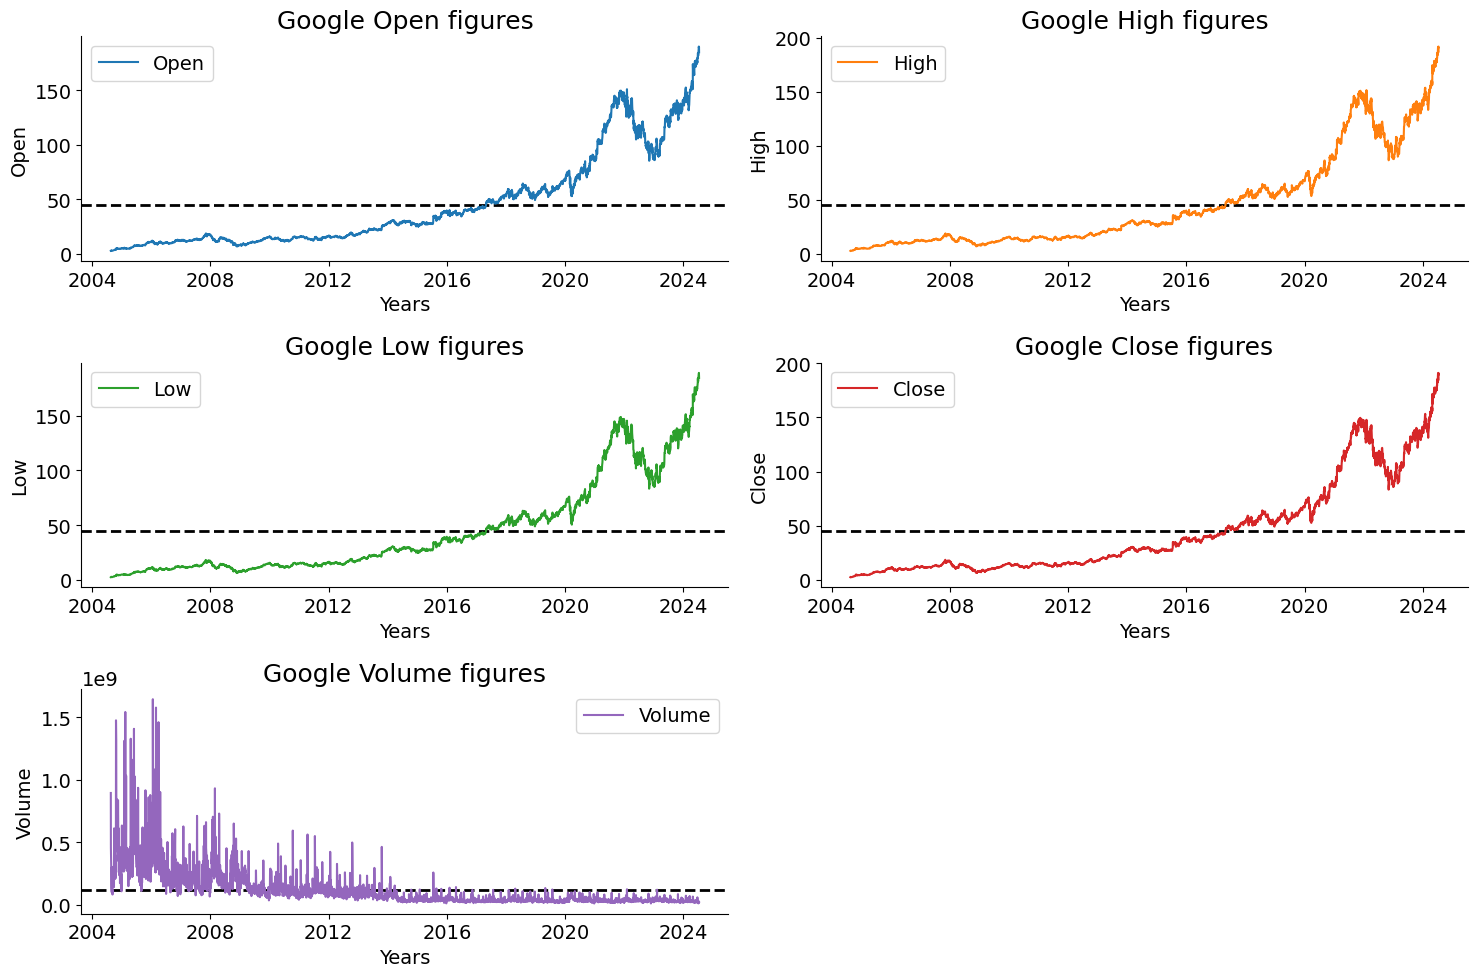

In [7]:
a = 3
b = 2
c = 1

colors = plt.rcParams["axes.prop_cycle"]()
fig = plt.figure(figsize=(15,10))

for i in range(len(data_hist.columns[:-2])):
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    plt.plot(data_hist[data_hist.columns[i]], color = color)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.axhline(data_hist[data_hist.columns[i]].mean(), linestyle='--', lw=2, zorder=1, color='black')
    plt.title("Google "+data_hist.columns[i] + " figures", fontsize=18)
    plt.xlabel('Years')
    plt.ylabel(data_hist.columns[i])
    plt.legend([data_hist.columns[i]])
    c = c + 1

plt.tight_layout()
plt.show()

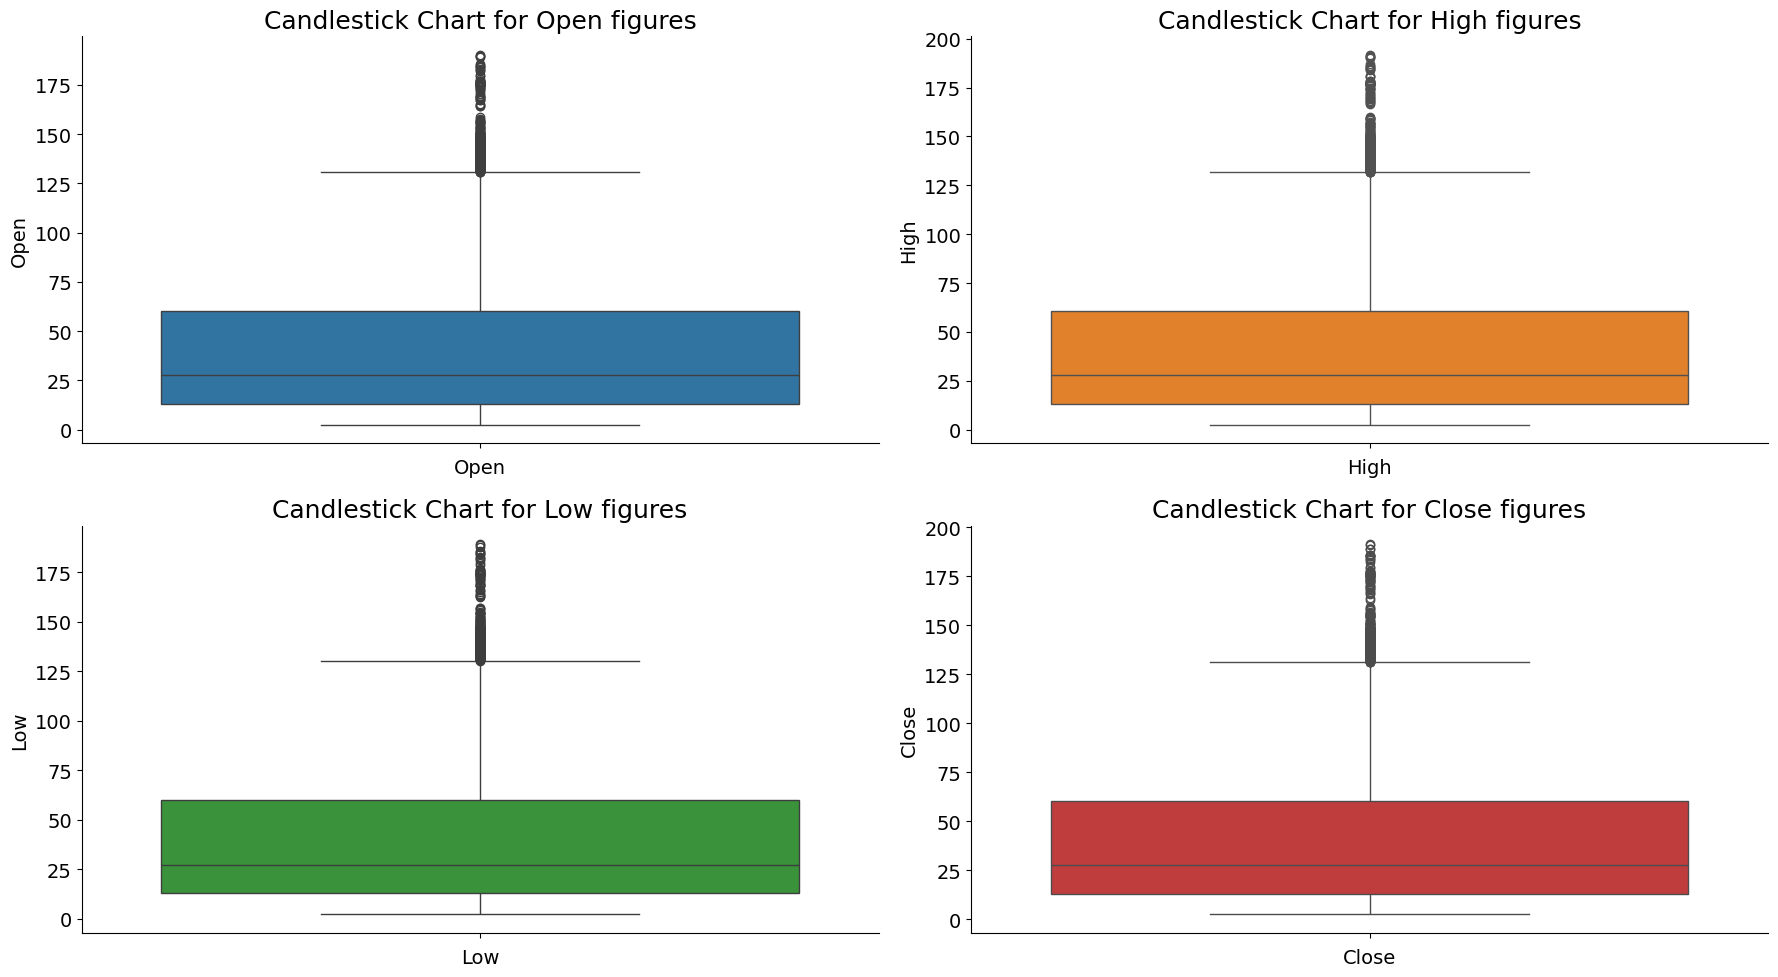

In [8]:
colors = plt.rcParams["axes.prop_cycle"]()

a = 2
b = 2
c = 1

fig = plt.figure(figsize=(18,10))

for i in range(len(data_hist.columns[:-3])):
    color = next(colors)["color"]
    plt.subplot(a, b, c)
    sns.boxplot(data_hist[data_hist.columns[i]], color= color )
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(data_hist.columns[i])
    plt.title(f'Candlestick Chart for {data_hist.columns[i]} figures', fontsize=18)
    c = c + 1

plt.tight_layout()
plt.show()

In [9]:
def candlestick(t, o, h, l, c):
    """
    # This function takes in five variables, t (time), o (open price), h (high price),
    l (low price), c (close price) to plot a candlestick chart.
    """

    plt.figure(figsize=(22,5))
    color = ["green" if close_price > open_price else "red" for close_price, open_price in zip(c, o)]
    plt.bar(x=t, height=np.abs(o-c), bottom=np.min((o,c), axis=0), color=color)
    plt.bar(x=t, height=h-l, bottom=l, color=color)
    plt.grid(visible=False)
    plt.title('Candlestick Chart')

In [10]:
today = date.today()
start = '2020-12-31'
end = today

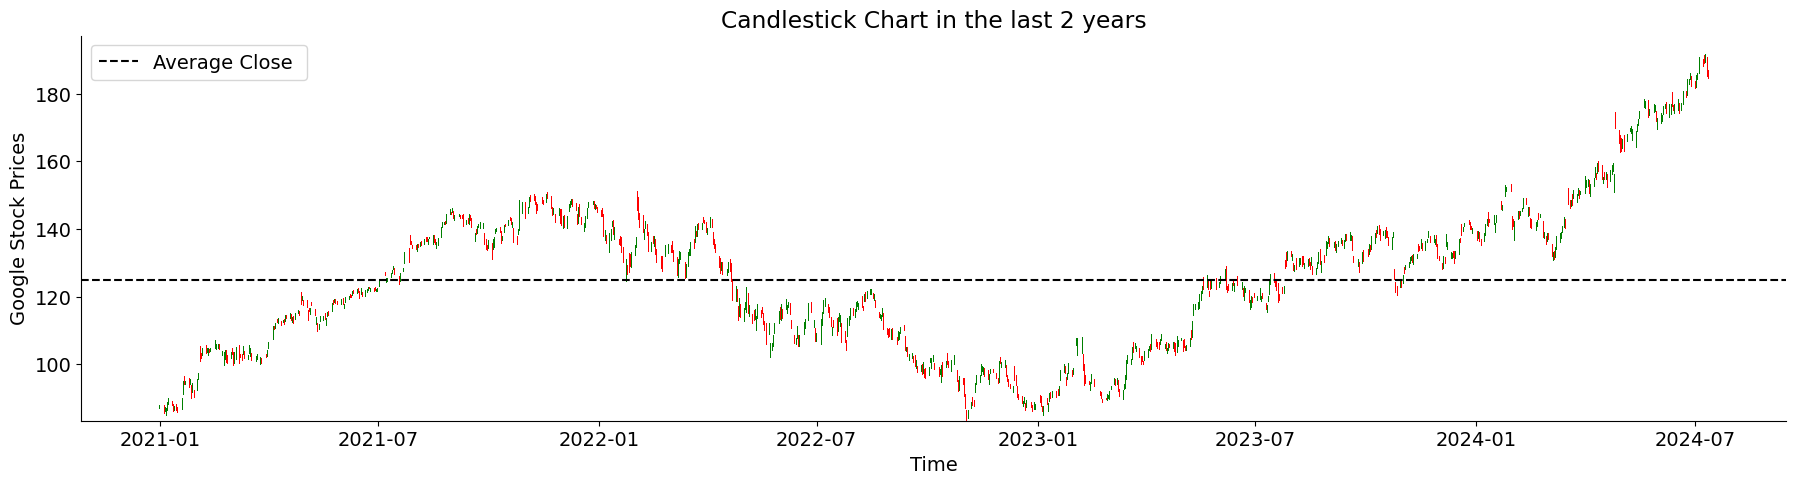

In [11]:
data_hist.index = data_hist.index.tz_localize(None)
candlestick(
    data_hist[start:end].index,
    data_hist[start:end]["Open"],
    data_hist[start:end]["High"],
    data_hist[start:end]["Low"],
    data_hist[start:end]["Close"]
)
plt.axhline(data_hist[start:end]["Close"].mean(), linestyle="--", color='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Time')
plt.ylabel('Google Stock Prices')
plt.title('Candlestick Chart in the last 2 years')
plt.legend(['Average Close '])
plt.show()

In [12]:
data_hist["Target"] = data_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [13]:
df = data_hist.copy()
df = df.shift(1)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Target
Date,,,,,,,,
2004-08-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-08-20,2.499634,2.601119,2.398648,2.508132,893181924.0,0.0,0.0,NaN
2004-08-23,2.524880,2.726600,2.512132,2.707353,456686856.0,0.0,0.0,1.0
2004-08-24,2.768345,2.836584,2.725851,2.734599,365122512.0,0.0,0.0,1.0
2004-08-25,2.780593,2.789591,2.588871,2.621365,304946748.0,0.0,0.0,0.0


In [14]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

df = df[["Open", "High", "Low", "Close", "Volume",'Target']].iloc[2:]

df.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2004-08-23,2.524880,2.726600,2.512132,2.707353,456686856.0,1.0
2004-08-24,2.768345,2.836584,2.725851,2.734599,365122512.0,1.0
2004-08-25,2.780593,2.789591,2.588871,2.621365,304946748.0,0.0
2004-08-26,2.623616,2.699605,2.596620,2.649612,183772044.0,1.0
2004-08-27,2.623365,2.698354,2.616117,2.697354,141897960.0,1.0


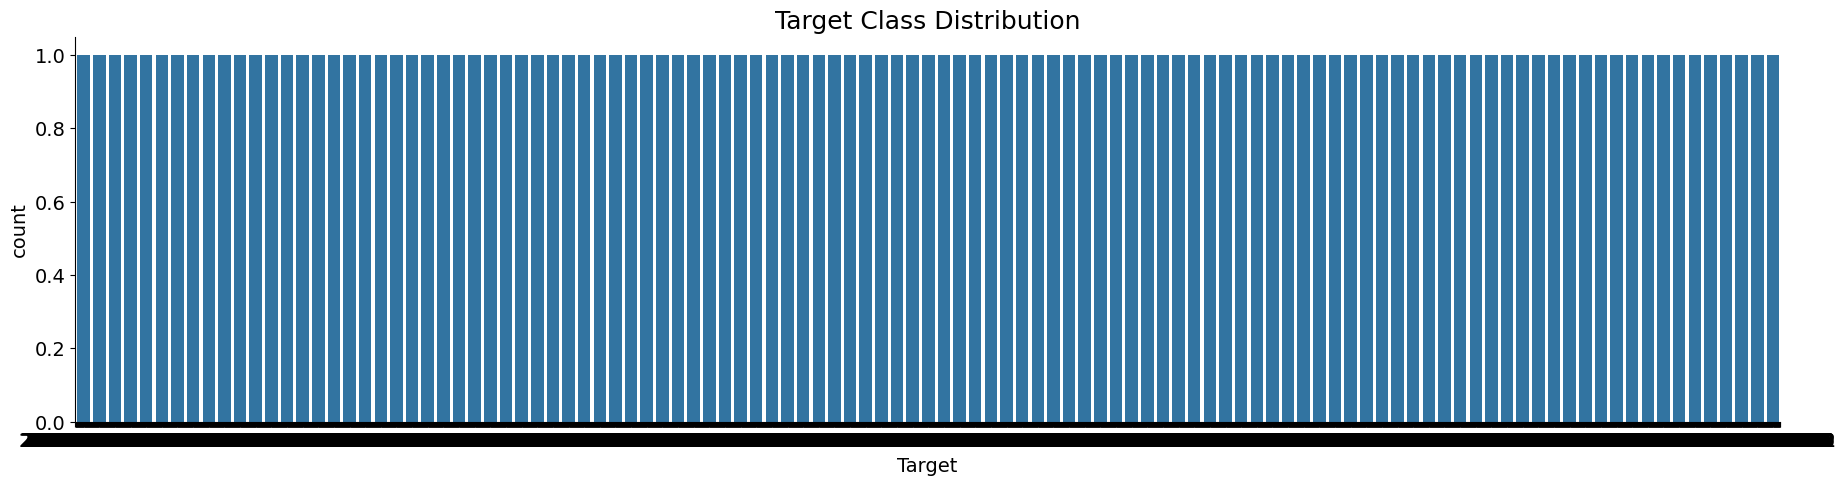

In [15]:
sns.countplot(df['Target'])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Target')
plt.title('Target Class Distribution', fontsize=18)
plt.show()

In [16]:
ros = RandomOverSampler(random_state=0)

X = df[["Open", "High", "Low", "Close", "Volume"]]

y = df['Target'].values

X_resampled, y_resampled  = ros.fit_resample(X,y)

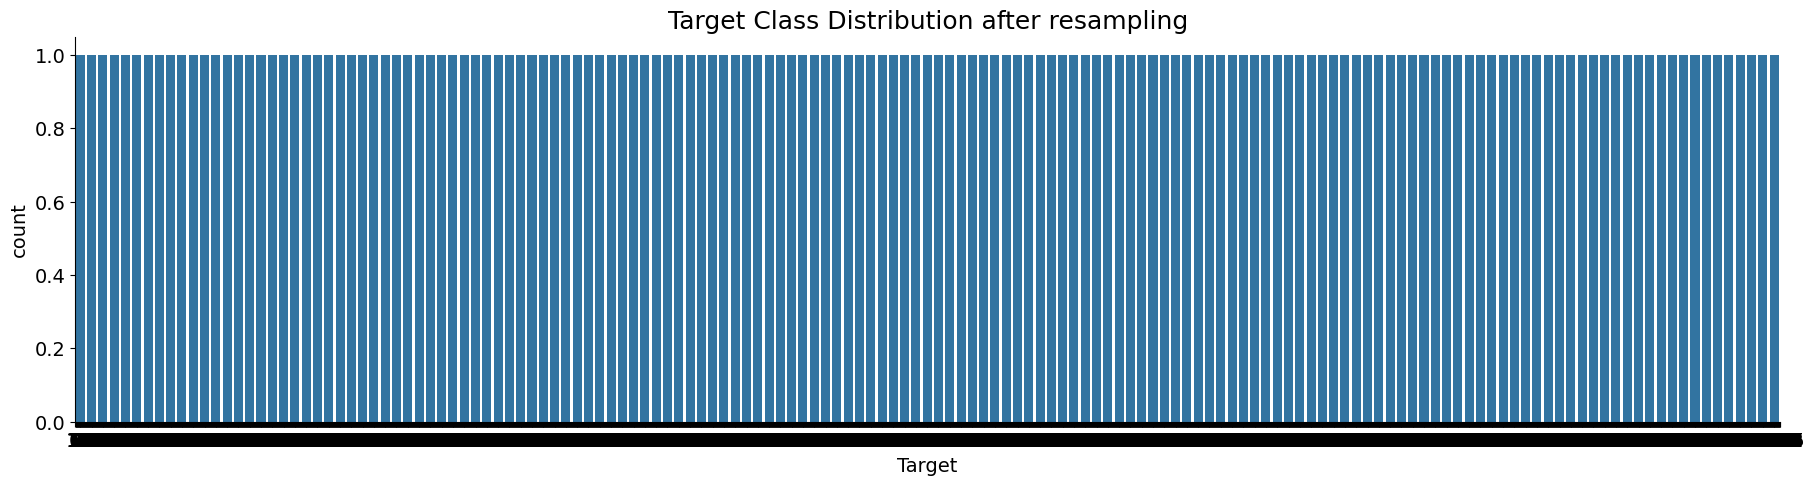

In [17]:
sns.countplot(y_resampled)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Target')
plt.title('Target Class Distribution after resampling', fontsize=18)
plt.show()

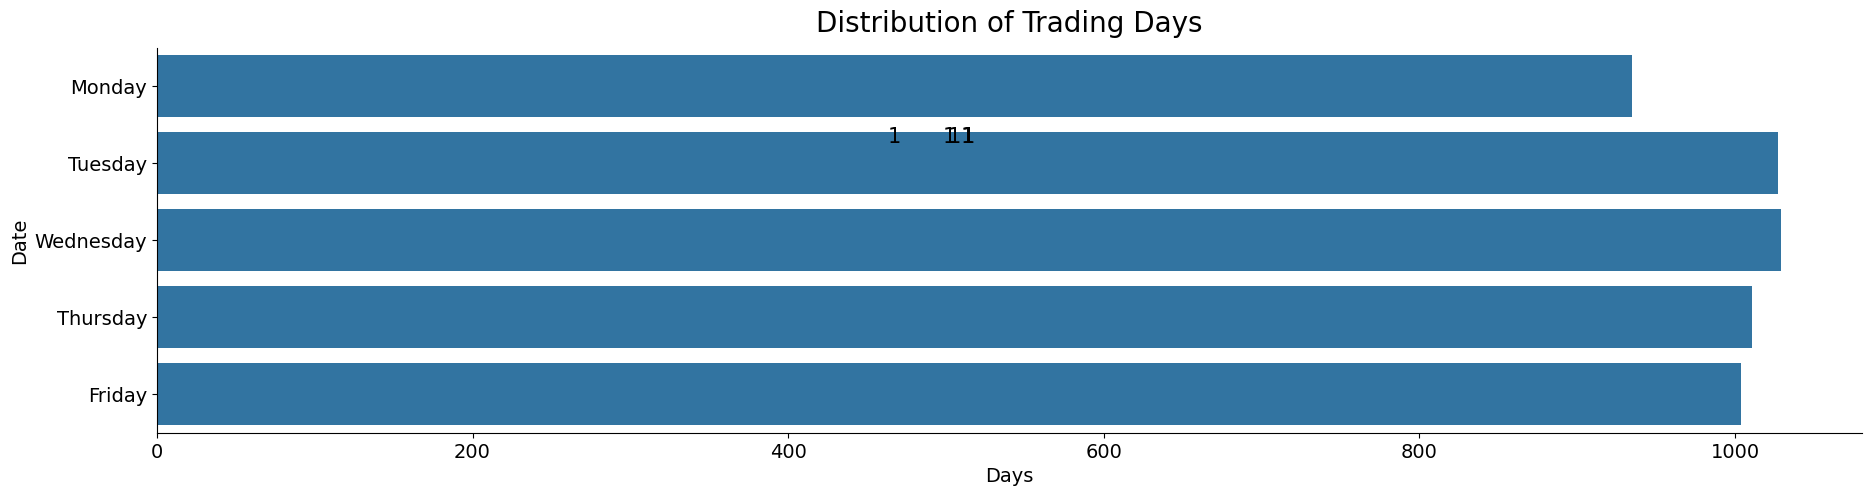

In [18]:
ax = sns.countplot(df.index.day_name())

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.xlabel('Days')

plt.title('Distribution of Trading Days', y=1.02, fontsize=20)

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),(bar.get_x() + bar.get_width() / 2,bar.get_height()),
                 ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')

plt.show()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse


In [20]:
weekly_mean = df.rolling(7).mean()
quarterly_mean = df.rolling(90).mean()
annual_mean = df.rolling(365).mean()

weekly_trend = df.shift(1).rolling(7).mean()["Target"]

df["weekly_mean"] = weekly_mean["Close"] / df["Close"]
df["quarterly_mean"] = quarterly_mean["Close"] / df["Close"]
df["annual_mean"] = annual_mean["Close"] / df["Close"]

df["annual_weekly_mean"] = df["annual_mean"] / df["weekly_mean"]
df["annual_quarterly_mean"] = df["annual_mean"] / df["quarterly_mean"]
df["weekly_trend"] = weekly_trend

df["open_close_ratio"] = df["Open"] / df["Close"]

df["high_close_ratio"] = df["High"] / df["Close"]

df["low_close_ratio"] = df["Low"] / df["Close"]

In [21]:
df

,Open,High,Low,Close,Volume,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,,,
2004-08-23,2.524880,2.726600,2.512132,2.707353,456686856.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.932601,1.007109,0.927892
2004-08-24,2.768345,2.836584,2.725851,2.734599,365122512.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.012340,1.037294,0.996801
2004-08-25,2.780593,2.789591,2.588871,2.621365,304946748.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.060742,1.064175,0.987604
2004-08-26,2.623616,2.699605,2.596620,2.649612,183772044.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.990189,1.018868,0.980000
2004-08-27,2.623365,2.698354,2.616117,2.697354,141897960.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.972570,1.000371,0.969882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,185.860001,190.860001,185.800003,190.600006,20967500.0,1.0,0.971436,0.851939,0.698042,0.718567,0.819357,0.714286,0.975131,1.001364,0.974816
2024-07-09,189.899994,190.169998,187.779999,189.029999,21035900.0,0.0,0.983396,0.861972,0.705135,0.717040,0.818049,0.714286,1.004602,1.006031,0.993387
2024-07-10,190.309998,191.360001,188.720001,188.979996,15121400.0,0.0,0.986355,0.865302,0.706646,0.716422,0.816648,0.714286,1.007038,1.012594,0.998624


In [22]:
predictors  = ['Open', 'High','Low','Close','weekly_mean','quarterly_mean','annual_mean',
 'annual_weekly_mean','annual_quarterly_mean','weekly_trend','open_close_ratio','high_close_ratio','low_close_ratio']

In [23]:
NN_df = df[predictors]

In [24]:
NN_df.head()

,Open,High,Low,Close,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,
2004-08-23,2.524880,2.726600,2.512132,2.707353,NaN,NaN,NaN,NaN,NaN,NaN,0.932601,1.007109,0.927892
2004-08-24,2.768345,2.836584,2.725851,2.734599,NaN,NaN,NaN,NaN,NaN,NaN,1.012340,1.037294,0.996801
2004-08-25,2.780593,2.789591,2.588871,2.621365,NaN,NaN,NaN,NaN,NaN,NaN,1.060742,1.064175,0.987604
2004-08-26,2.623616,2.699605,2.596620,2.649612,NaN,NaN,NaN,NaN,NaN,NaN,0.990189,1.018868,0.980000
2004-08-27,2.623365,2.698354,2.616117,2.697354,NaN,NaN,NaN,NaN,NaN,NaN,0.972570,1.000371,0.969882


In [25]:
for i in range(len(NN_df.columns)):
    if NN_df[NN_df.columns[i]].isnull().sum()>0:
        print(f'Column {i} {NN_df.columns[i]} null values : {round(NN_df[NN_df.columns[i]].isnull().sum()/NN_df.shape[0]*100,2)}%')

Column 4 weekly_mean null values : 0.12%
Column 5 quarterly_mean null values : 1.78%
Column 6 annual_mean null values : 7.27%
Column 7 annual_weekly_mean null values : 7.27%
Column 8 annual_quarterly_mean null values : 7.27%
Column 9 weekly_trend null values : 0.14%


In [26]:
NN_df.fillna(0, inplace=True)

In [27]:
NN_df.isnull().sum()

Open                     0
High                     0
Low                      0
Close                    0
weekly_mean              0
quarterly_mean           0
annual_mean              0
annual_weekly_mean       0
annual_quarterly_mean    0
weekly_trend             0
open_close_ratio         0
high_close_ratio         0
low_close_ratio          0
dtype: int64

In [28]:
NN_df

,Open,High,Low,Close,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,weekly_trend,open_close_ratio,high_close_ratio,low_close_ratio
Date,,,,,,,,,,,,,
2004-08-23,2.524880,2.726600,2.512132,2.707353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.932601,1.007109,0.927892
2004-08-24,2.768345,2.836584,2.725851,2.734599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.012340,1.037294,0.996801
2004-08-25,2.780593,2.789591,2.588871,2.621365,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060742,1.064175,0.987604
2004-08-26,2.623616,2.699605,2.596620,2.649612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990189,1.018868,0.980000
2004-08-27,2.623365,2.698354,2.616117,2.697354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.972570,1.000371,0.969882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,185.860001,190.860001,185.800003,190.600006,0.971436,0.851939,0.698042,0.718567,0.819357,0.714286,0.975131,1.001364,0.974816
2024-07-09,189.899994,190.169998,187.779999,189.029999,0.983396,0.861972,0.705135,0.717040,0.818049,0.714286,1.004602,1.006031,0.993387
2024-07-10,190.309998,191.360001,188.720001,188.979996,0.986355,0.865302,0.706646,0.716422,0.816648,0.714286,1.007038,1.012594,0.998624


In [29]:
scaler = MinMaxScaler()
scaler.fit(NN_df[NN_df.columns])
NN_df[NN_df.columns] = scaler.transform(NN_df[NN_df.columns])

In [30]:
def df_to_X_y2(df, window_size=13):
    """
    Function to convert a dataframe of values into X (data) and y (labels)

    Parameters:
       df: Pandas DataFrame
       window_size: integer representing the size of the window to be used (default 16)

    Returns:
       X: Numpy array of data
       y: Numpy array of labels
    """

    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

In [31]:
X, y = df_to_X_y2(NN_df)

print(f'X shape {X.shape} y shape {y.shape}')
print(f'There are {X.shape[0]} samples, {X.shape[1]} timesteps and {X.shape[2]} features in the our data')

X shape (4993, 13, 13) y shape (4993,)
There are 4993 samples, 13 timesteps and 13 features in the our data


In [32]:
y

array([4.44484731e-04, 3.20723121e-04, 9.90106674e-04, ...,
       1.00000000e+00, 9.93824203e-01, 9.97551030e-01])

In [33]:
y = np.squeeze(scaler.fit_transform(np.expand_dims(y, axis=1)))

In [34]:
threshold = int(X.shape[0] * 0.75)

X_train, y_train = X[:threshold], y[:threshold]

X_test, y_test = X[threshold:], y[threshold:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3744, 13, 13)
y_train shape: (3744,)
X_test shape: (1249, 13, 13)
y_test shape: (1249,)


In [35]:

model = Sequential()

model.add(InputLayer((X_train.shape[1], X_train.shape[2])))

model.add(GRU(64))

model.add(Dense(8, 'relu'))

model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                15168     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 15697 (61.32 KB)
Trainable params: 15697 (61.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

In [37]:
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [38]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=callback)


Epoch 1/100
117/117 [==============================] - 4s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 5.4514e-04 - val_root_mean_squared_error: 0.0233
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 1.6834e-05 - root_mean_squared_error: 0.0041 - val_loss: 4.7789e-04 - val_root_mean_squared_error: 0.0219
Epoch 3/100
117/117 [==============================] - 1s 9ms/step - loss: 1.0446e-05 - root_mean_squared_error: 0.0032 - val_loss: 4.4804e-04 - val_root_mean_squared_error: 0.0212
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 7.1297e-06 - root_mean_squared_error: 0.0027 - val_loss: 4.1106e-04 - val_root_mean_squared_error: 0.0203
Epoch 5/100
117/117 [==============================] - 1s 9ms/step - loss: 6.6129e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.9783e-04 - val_root_mean_squared_error: 0.0199
Epoch 6/100
117/117 [==============================] - 1s 9ms/step - loss: 6.2491e-06 - root_mean_

In [39]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
test_results

40/40 [==============================] - 1s 4ms/step


,Test Predictions,Actuals
0,0.288433,0.289410
1,0.287274,0.313095
2,0.300516,0.316952
3,0.307259,0.312829
4,0.309843,0.312263
...,...,...
1244,0.868094,0.976301
1245,0.875974,0.997816
1246,0.880188,1.000000
1247,0.885753,0.993822


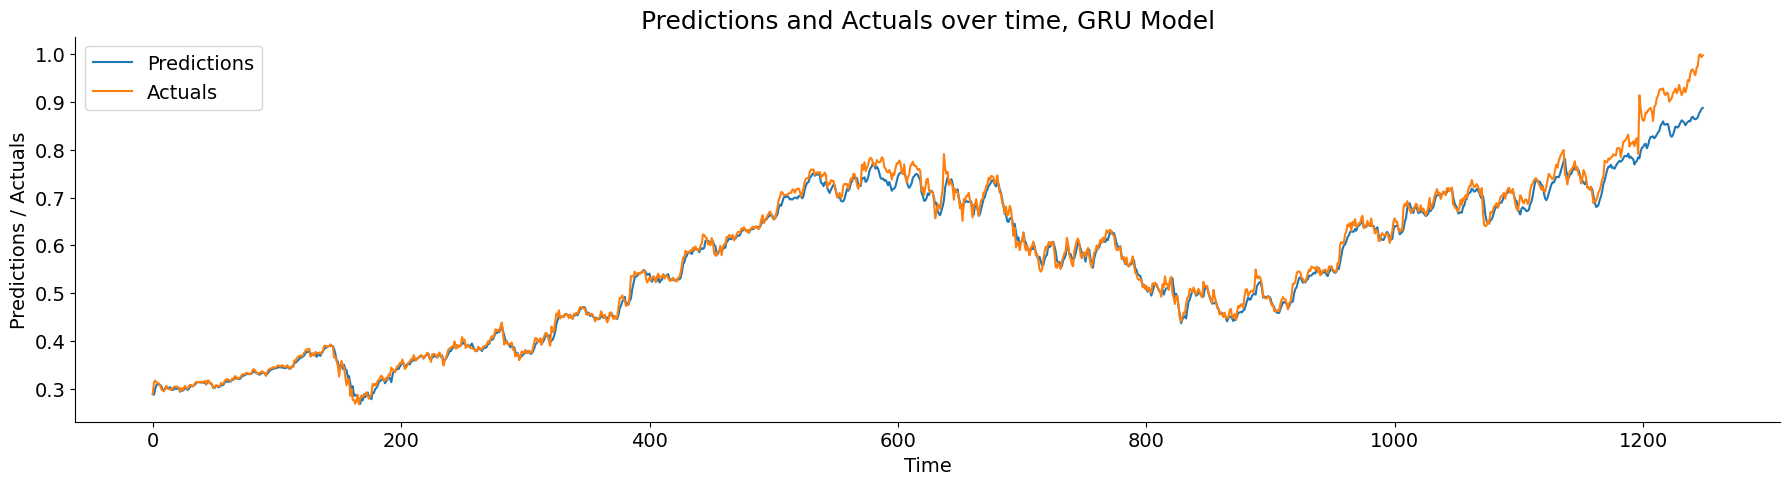

In [40]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(['Predictions', 'Actuals'])
plt.ylabel('Predictions / Actuals')
plt.xlabel('Time')
plt.title('Predictions and Actuals over time, GRU Model', fontsize=18)
plt.show()

In [41]:
print('MSE of the GRU model :', round(mse(test_results['Test Predictions'], test_results['Actuals']),6))

MSE of the GRU model : 0.000438
